In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:


# Load the uploaded files to inspect the data
files = {
    'demand_actual': 'nsw_demand_actual.csv',
    'demand_forecast': 'nsw_demand_forecast.csv',
    'merged_all': 'nsw_merged_all.csv',
    'pricedat': 'nsw_pricedat.csv',
    'prices': 'nsw_prices.csv',
    'solar': 'nsw_solar.csv',
}

# Load the datasets
demand_actual = pd.read_csv(files['demand_actual'])
demand_forecast = pd.read_csv(files['demand_forecast'])
merged_all = pd.read_csv(files['merged_all'])
pricedat = pd.read_csv(files['pricedat'])
prices = pd.read_csv(files['prices'])
solar = pd.read_csv(files['solar'])

# Show the first few rows of each dataframe to understand their structure
{
    "demand_actual": demand_actual.head(),
    "demand_forecast": demand_forecast.head(),
    "merged_all": merged_all.head(),
    "pricedat": pricedat.head(),
    "prices": prices.head(),
    "solar": solar.head(),
}


{'demand_actual':              date_time  OPERATIONAL_DEMAND
 0  2022-01-01 00:00:00                7329
 1  2022-01-01 00:30:00                7145
 2  2022-01-01 01:00:00                6891
 3  2022-01-01 01:30:00                6578
 4  2022-01-01 02:00:00                6306,
 'demand_forecast':              date_time  OPERATIONAL_DEMAND_POE10  OPERATIONAL_DEMAND_POE50  \
 0  2022-01-01 00:00:00                    7451.0                      7336   
 1  2022-01-01 00:30:00                    7288.0                      7151   
 2  2022-01-01 01:00:00                    7032.0                      6899   
 3  2022-01-01 01:30:00                    6711.0                      6585   
 4  2022-01-01 02:00:00                    6450.0                      6328   
 
    OPERATIONAL_DEMAND_POE90  
 0                    7221.0  
 1                    7013.0  
 2                    6766.0  
 3                    6458.0  
 4                    6206.0  ,
 'merged_all':              date_tim

In [3]:
# Merge the relevant datasets on 'date_time'

# First, make sure the 'date_time' columns are in datetime format
demand_actual['date_time'] = pd.to_datetime(demand_actual['date_time'])
demand_forecast['date_time'] = pd.to_datetime(demand_forecast['date_time'])
prices['date_time'] = pd.to_datetime(prices['date_time'])
solar['INTERVAL_DATETIME'] = pd.to_datetime(solar['INTERVAL_DATETIME'])

# Rename 'INTERVAL_DATETIME' to 'date_time' for solar data to enable merging
solar = solar.rename(columns={'INTERVAL_DATETIME': 'date_time'})

# Merge the actual demand, forecast demand, prices, and solar data on 'date_time'
merged_data = demand_actual.merge(demand_forecast, on='date_time', how='left') \
                           .merge(prices, on='date_time', how='left') \
                           .merge(solar, on='date_time', how='left')

In [4]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89755 entries, 0 to 89754
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_time                 89755 non-null  datetime64[ns]
 1   OPERATIONAL_DEMAND        89755 non-null  int64         
 2   OPERATIONAL_DEMAND_POE10  89755 non-null  float64       
 3   OPERATIONAL_DEMAND_POE50  89755 non-null  int64         
 4   OPERATIONAL_DEMAND_POE90  89755 non-null  float64       
 5   RRP                       89751 non-null  float64       
 6   TYPE                      89751 non-null  object        
 7   POWER                     89746 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.5+ MB


In [5]:
print('Before fix',merged_data.isnull().sum())

# Fill missing values for numeric columns with the column mean
merged_data['RRP'].fillna(merged_data['RRP'].mean(), inplace=True)
merged_data['POWER'].fillna(merged_data['POWER'].mean(), inplace=True)

# Fill missing values for the 'TYPE' column with the most frequent value (mode)
merged_data['TYPE'].fillna(merged_data['TYPE'].mode()[0], inplace=True)

# Verify that there are no more missing values
print('\nAfter fix\n',merged_data.isnull().sum())

Before fix date_time                   0
OPERATIONAL_DEMAND          0
OPERATIONAL_DEMAND_POE10    0
OPERATIONAL_DEMAND_POE50    0
OPERATIONAL_DEMAND_POE90    0
RRP                         4
TYPE                        4
POWER                       9
dtype: int64

After fix
 date_time                   0
OPERATIONAL_DEMAND          0
OPERATIONAL_DEMAND_POE10    0
OPERATIONAL_DEMAND_POE50    0
OPERATIONAL_DEMAND_POE90    0
RRP                         0
TYPE                        0
POWER                       0
dtype: int64


/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_28006/1013594667.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['RRP'].fillna(merged_data['RRP'].mean(), inplace=True)
/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_28006/1013594667.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

### Feature

In [6]:
# Difference between forecast and actual demand
merged_data['demand_error'] = merged_data['OPERATIONAL_DEMAND'] - merged_data['OPERATIONAL_DEMAND_POE50']

# # Calculate the percentage change in RRP (price)
# merged_data['price_spike'] = merged_data['RRP'].pct_change() * 100

# Price spike indicator (e.g., when RRP increases by 20% within 30 mins)
merged_data['price_spike'] = (merged_data['RRP'].pct_change() > 0.2).astype(int)

# Lagged demand and prices (shifting by one interval)
merged_data['lagged_demand'] = merged_data['OPERATIONAL_DEMAND'].shift(1)
merged_data['lagged_RRP'] = merged_data['RRP'].shift(1)
merged_data['price_spike'].value_counts()

price_spike
0    81487
1     8268
Name: count, dtype: int64

In [7]:
# merged_data['price_spike'] = merged_data['price_spike'].rolling(window=3).mean()
# merged_data['price_pct_change_clipped'] = np.clip(merged_data['price_spike'], -100, 100)

# # Summary statistics after clipping
# print(merged_data['price_pct_change_clipped'].describe())

# # Visualize the distribution of the clipped percentage changes
# plt.figure(figsize=(10,6))
# sns.histplot(merged_data['price_pct_change_clipped'], bins=100, kde=True)
# plt.title('Distribution of Clipped Price Percentage Change')
# plt.show()

In [8]:
# # Rolling standard deviation of percentage changes (to analyze price volatility)
# merged_data['price_volatility'] = merged_data['price_spike'].rolling(window=5).std()

# # Plot volatility over time
# plt.figure(figsize=(14,8))
# plt.plot(merged_data['date_time'], merged_data['price_volatility'], label='Price Volatility', color='orange')
# plt.title('Price Volatility (Rolling Std of Price % Change)')
# plt.xlabel('Time')
# plt.ylabel('Volatility')
# plt.legend()
# plt.show()


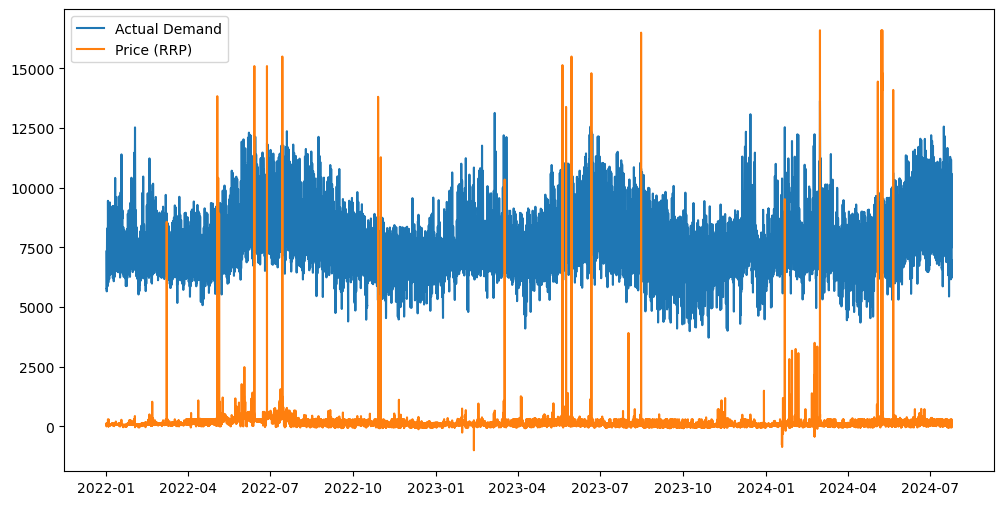

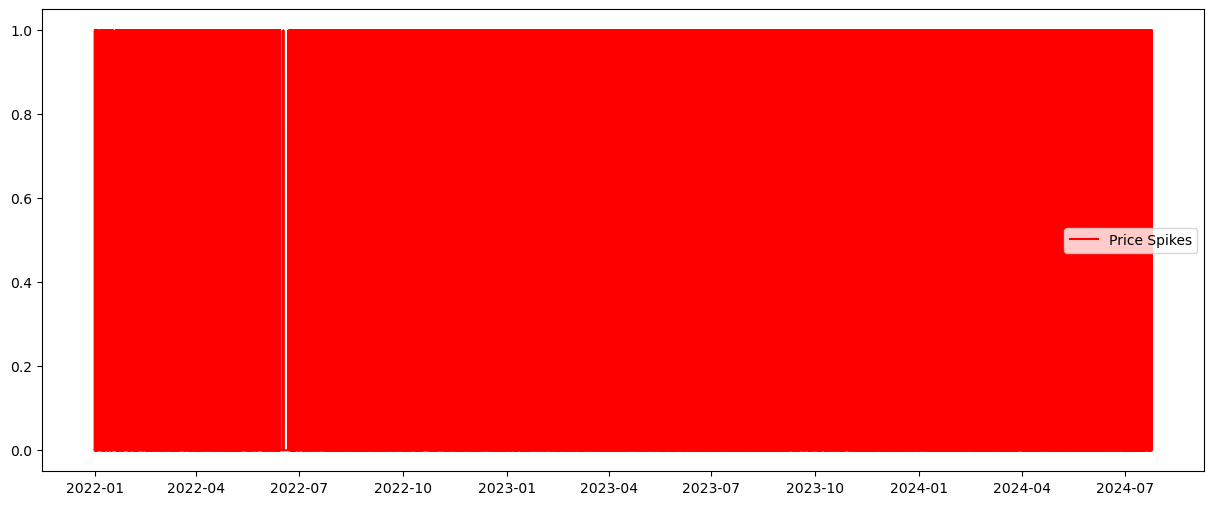

In [9]:
import matplotlib.pyplot as plt

# Plot demand and prices over time
plt.figure(figsize=(12,6))
plt.plot(merged_data['date_time'], merged_data['OPERATIONAL_DEMAND'], label='Actual Demand')
plt.plot(merged_data['date_time'], merged_data['RRP'], label='Price (RRP)')
plt.legend()
plt.show()

# Plot price spikes
plt.figure(figsize=(15,6))
plt.plot(merged_data['date_time'], merged_data['price_spike'], label='Price Spikes', color='red')
plt.legend()
plt.show()

In [10]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

# # Select features and target variable
# features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER']
# target = 'price_spike'

# # Extract features and target
# X = merged_data[features].values
# y = merged_data[target].values

# # Scaling the features (MinMax scaling)
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(X)

# # Define the number of time steps (e.g., using a window of 10 time steps)
# n_steps = 10

# # Function to create sequences of data for LSTM input
# def create_sequences(X, y, n_steps):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - n_steps):
#         X_seq.append(X[i:i + n_steps])
#         y_seq.append(y[i + n_steps])
#     return np.array(X_seq), np.array(y_seq)

# # Create sequences
# X_seq, y_seq = create_sequences(X_scaled, y, n_steps)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [11]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Bidirectional LSTM layer (first LSTM layer with bidirectional support)
# model = Sequential()
# model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2]))))

# # Second LSTM layer (return_sequences=True so that the next layer gets the full sequence)
# model.add(LSTM(64, activation='relu', return_sequences=True))

# # Add Dropout layer to reduce overfitting after each LSTM layer
# model.add(Dropout(0.3))

# # Third LSTM layer (final LSTM layer doesn't need return_sequences)
# model.add(LSTM(32, activation='relu', return_sequences=True))

# # Add an RNN layer for additional processing
# model.add(SimpleRNN(32, activation='relu'))

# # Add another Dropout layer before the final output
# model.add(Dropout(0.3))

# # Dense output layer for binary classification
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model with Adam optimizer and a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])



In [12]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")

# # Make predictions on the test set
# y_pred = (model.predict(X_test) > 0.5).astype("int32")

# # Import classification metrics
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [13]:
# import matplotlib.pyplot as plt

# # Get accuracy and loss from history
# history_dict = history.history

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))

# # Accuracy Plot
# plt.subplot(1, 2, 1)
# plt.plot(history_dict['accuracy'], label='Training Accuracy')
# plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# # Loss Plot
# plt.subplot(1, 2, 2)
# plt.plot(history_dict['loss'], label='Training Loss')
# plt.plot(history_dict['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()

# # Display the plots
# plt.tight_layout()
# plt.show()


In [14]:
# import matplotlib.pyplot as plt

# # Get predicted values
# y_pred = (model.predict(X_test) > 0.5).astype("int32")

# # Plot the actual and predicted price spikes
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='Actual Price Spikes', color='blue')
# plt.plot(y_pred, label='Predicted Price Spikes', color='red', linestyle='dashed')
# plt.title('Actual vs Predicted Price Spikes')
# plt.xlabel('Time Steps')
# plt.ylabel('Price Spike (0 or 1)')
# plt.legend()
# plt.show()


In [15]:
# # Get predicted price values
# y_pred = model.predict(X_test)

# # Plot actual vs predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='Actual Prices', color='blue')
# plt.plot(y_pred, label='Predicted Prices', color='red', linestyle='dashed')
# plt.title('Actual vs Predicted Prices')
# plt.xlabel('Time Steps')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


## Day wise

In [16]:
# Assuming your 'date_time' column is in datetime format
merged_data['day_of_week'] = pd.to_datetime(merged_data['date_time']).dt.dayofweek
merged_data['hour_of_day'] = pd.to_datetime(merged_data['date_time']).dt.hour

## Loading weather data, i.e. temperature
- The column names in the data are mentioned by city codes, where sydney is 66214. Sydney is the capital of NSW.
- Another problem we are going to see is the merged data have ~88k rows where as our temperature data have ~23k rows, so after merging there will be a lot of null values which we will fix by fill them with avg values such as that we aleast get some close values.
- Fill them with 0 will be a wrong decision as it will give us wrong predictions. 

In [17]:
# Load the weather data (assuming it has 'date_time' and 'temperature' columns) Sydney=66214
weather_data = pd.read_csv('CCtemps.csv')
weather_data = weather_data.rename(columns={'valid_start_UTC':'date_time'})
weather_data = weather_data.drop(columns = ['23000','40913','70351','86282','94250'])
weather_data = weather_data.rename(columns={'66214':'temperature'})
weather_data

,date_time,temperature
0,31/12/2021 15:00,21.7
1,31/12/2021 16:00,21.5
2,31/12/2021 17:00,21.1
3,31/12/2021 18:00,20.8
4,31/12/2021 19:00,20.9
...,...,...
22747,5/08/2024 10:00,12.5
22748,5/08/2024 11:00,12.9
22749,5/08/2024 12:00,12.7
22750,5/08/2024 13:00,12.1


#### Lets change the date time col data type

In [18]:
# Ensure the 'date_time' columns are in datetime format
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

# Merge the weather data with your merged dataset on 'date_time'
merged_data = pd.merge(merged_data, weather_data[['date_time', 'temperature']], on='date_time', how='left')
merged_data.isnull().sum()

/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_28006/3915404511.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])


date_time                       0
OPERATIONAL_DEMAND              0
OPERATIONAL_DEMAND_POE10        0
OPERATIONAL_DEMAND_POE50        0
OPERATIONAL_DEMAND_POE90        0
RRP                             0
TYPE                            0
POWER                           0
demand_error                    0
price_spike                     0
lagged_demand                   1
lagged_RRP                      1
day_of_week                     0
hour_of_day                     0
temperature                 45222
dtype: int64

### Now as we can see above that there are ~45k null values in temp data and 1 each in lagged_demand and lagged_RRP.
#### lets fill them with .mean()

In [19]:
merged_data['lagged_demand'].fillna(merged_data['lagged_demand'].mean(), inplace=True)
merged_data['lagged_RRP'].fillna(merged_data['lagged_RRP'].mean(), inplace=True)
# merged_data['price_spike'].fillna(merged_data['price_spike'].mean(), inplace=True)
merged_data['price_spike'].fillna(0, inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)

/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_28006/2882804692.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['lagged_demand'].fillna(merged_data['lagged_demand'].mean(), inplace=True)
/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_28006/2882804692.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Updated feature list with new features
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'

# Extract features and target
X = merged_data[features].values
y = merged_data[target].values

print(X)
print(y)

# Scale the features (including the new ones)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

[[ 7.32900000e+03 -7.00000000e+00  7.68408081e+03 ...  5.00000000e+00
   0.00000000e+00  2.65000000e+01]
 [ 7.32900000e+03 -7.00000000e+00  7.32900000e+03 ...  5.00000000e+00
   0.00000000e+00  2.65000000e+01]
 [ 7.14500000e+03 -6.00000000e+00  7.32900000e+03 ...  5.00000000e+00
   0.00000000e+00  1.82329037e+01]
 ...
 [ 6.62500000e+03 -2.40000000e+01  6.41600000e+03 ...  2.00000000e+00
   1.40000000e+01  1.82329037e+01]
 [ 6.62500000e+03 -2.40000000e+01  6.62500000e+03 ...  2.00000000e+00
   1.40000000e+01  1.82329037e+01]
 [ 6.95400000e+03  2.40000000e+01  6.62500000e+03 ...  2.00000000e+00
   1.50000000e+01  1.51000000e+01]]
[0 0 0 ... 0 0 1]


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the number of time steps (e.g., using a window of 10 time steps)
n_steps = 10

# Function to create sequences of data for LSTM input
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i + n_steps])
        y_seq.append(y[i + n_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Bidirectional LSTM layer (first LSTM layer with bidirectional support)
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2]))))

# Second LSTM layer (return_sequences=True so that the next layer gets the full sequence)
model.add(LSTM(64, activation='relu', return_sequences=True))

# Add Dropout layer to reduce overfitting after each LSTM layer
model.add(Dropout(0.3))

# Third LSTM layer (final LSTM layer doesn't need return_sequences)
model.add(LSTM(32, activation='relu', return_sequences=True))

# Add an RNN layer for additional processing
model.add(SimpleRNN(32, activation='relu'))

# Add another Dropout layer before the final output
model.add(Dropout(0.3))

# Dense output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9074 - loss: 0.3719 - val_accuracy: 0.8929 - val_loss: 0.3297
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9134 - loss: 0.2907 - val_accuracy: 0.8929 - val_loss: 0.3260
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9120 - loss: 0.2900 - val_accuracy: 0.8929 - val_loss: 0.3254
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9103 - loss: 0.2955 - val_accuracy: 0.8929 - val_loss: 0.3248
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9136 - loss: 0.2853 - val_accuracy: 0.8929 - val_loss: 0.3280
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9111 - loss: 0.2926 - val_accuracy: 0.8929 - val_loss: 0.3247
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9123 - loss: 0.2889 - val_accuracy: 0.8929 - val_loss: 0.3238
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9087 - loss: 0.29

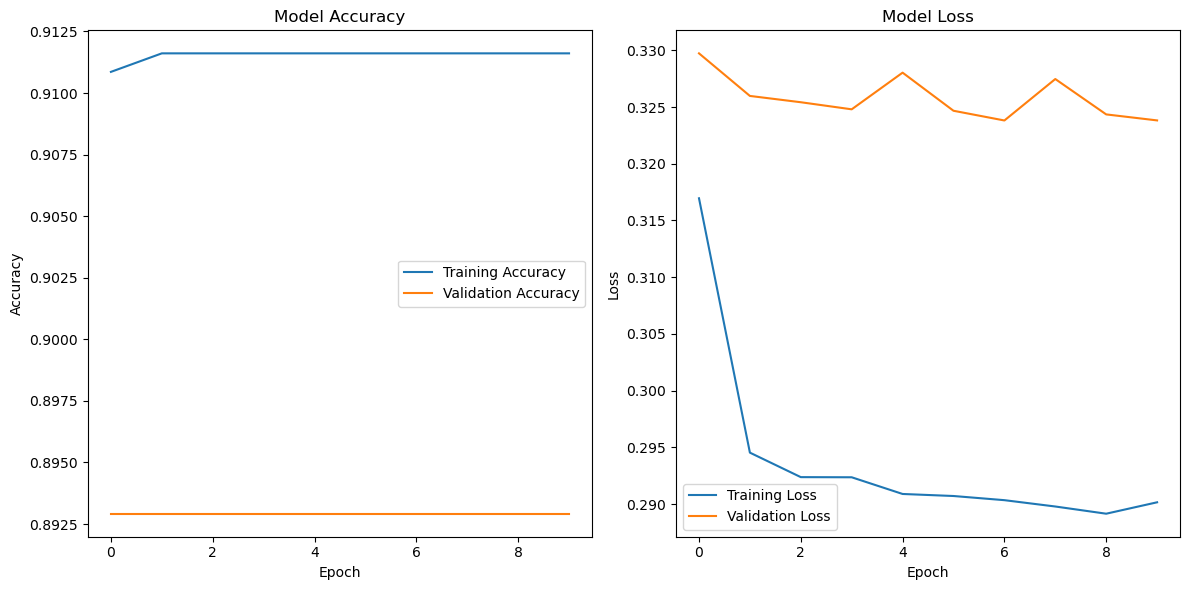

In [22]:
import matplotlib.pyplot as plt

# Get accuracy and loss from history
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Import classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8952 - loss: 0.3231
Test Loss: 0.3238130509853363
Test Accuracy: 0.8929188251495361
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     16027
           1       0.00      0.00      0.00      1922

    accuracy                           0.89     17949
   macro avg       0.45      0.50      0.47     17949
weighted avg       0.80      0.89      0.84     17949



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Seasonal analysis

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score

# Assign seasons based on month
def assign_season(month):
    if month in [12, 1, 2]:  # Summer
        return 'Summer'
    elif month in [3, 4, 5]:  # Autumn
        return 'Autumn'
    elif month in [6, 7, 8]:  # Winter
        return 'Winter'
    else:  # Spring
        return 'Spring'

# Apply season assignment to the merged data
merged_data['season'] = merged_data['date_time'].dt.month.apply(assign_season)

merged_data

,date_time,OPERATIONAL_DEMAND,OPERATIONAL_DEMAND_POE10,OPERATIONAL_DEMAND_POE50,OPERATIONAL_DEMAND_POE90,RRP,TYPE,POWER,demand_error,price_spike,lagged_demand,lagged_RRP,day_of_week,hour_of_day,temperature,season
0,2022-01-01 00:00:00,7329,7451.0,7336,7221.0,124.77,MEASUREMENT,0.000000,-7,0,7684.08081,137.8653,5,0,26.500000,Summer
1,2022-01-01 00:00:00,7329,7451.0,7336,7221.0,124.77,SATELLITE,0.000000,-7,0,7329.00000,124.7700,5,0,26.500000,Summer
2,2022-01-01 00:30:00,7145,7288.0,7151,7013.0,124.06,MEASUREMENT,0.000000,-6,0,7329.00000,124.7700,5,0,18.232904,Summer
3,2022-01-01 00:30:00,7145,7288.0,7151,7013.0,124.06,SATELLITE,0.000000,-6,0,7145.00000,124.0600,5,0,18.232904,Summer
4,2022-01-01 01:00:00,6891,7032.0,6899,6766.0,93.63,MEASUREMENT,0.000000,-8,0,7145.00000,124.0600,5,1,26.400000,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89750,2024-07-24 14:00:00,6416,6435.0,6337,6238.0,-11.37,MEASUREMENT,2770.400000,79,0,6233.00000,0.0000,2,14,15.200000,Winter
89751,2024-07-24 14:00:00,6416,6435.0,6337,6238.0,-11.37,SATELLITE,2467.828000,79,0,6416.00000,-11.3700,2,14,15.200000,Winter
89752,2024-07-24 14:30:00,6625,6753.0,6649,6545.0,33.64,MEASUREMENT,2445.089000,-24,0,6416.00000,-11.3700,2,14,18.232904,Winter
89753,2024-07-24 14:30:00,6625,6753.0,6649,6545.0,33.64,SATELLITE,2141.324000,-24,0,6625.00000,33.6400,2,14,18.232904,Winter


In [26]:

# Define a function to create LSTM model for each season (for both price and demand prediction)
def create_lstm_model_for_season(season_data, target='OPERATIONAL_DEMAND', n_steps=10):
    # Extract features and target for the season
    features = ['OPERATIONAL_DEMAND', 'POWER', 'lagged_demand', 'RRP', 'day_of_week', 'hour_of_day', 'temperature']
    X = season_data[features].values
    y = season_data[target].values

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Create sequences for LSTM
    def create_sequences(X, y, n_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - n_steps):
            X_seq.append(X[i:i + n_steps])
            y_seq.append(y[i + n_steps])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_scaled, y, n_steps)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Predict either demand or price

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # For demand predictions, calculate RMSE
    if target == 'OPERATIONAL_DEMAND':
        predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 6))], axis=1))[:,0]
        y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))], axis=1))[:,0]
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        print(f'{season} {target} RMSE: {rmse}')
        return rmse

    # For price spikes, calculate accuracy
    else:
        predictions = (predictions > 0.5).astype(int)  # Binary classification for price spikes
        accuracy = accuracy_score(y_test, predictions)
        print(f'{season} {target} Accuracy: {accuracy}')
        return accuracy

# Iterate over each season and train models for demand and price prediction
seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
results = {}

for season in seasons:
    print(f"\nTraining LSTM model for {season} (Demand Prediction)...")
    season_data = merged_data[merged_data['season'] == season]
    rmse_demand = create_lstm_model_for_season(season_data, target='OPERATIONAL_DEMAND')

    print(f"\nTraining LSTM model for {season} (Price Spike Prediction)...")
    accuracy_price = create_lstm_model_for_season(season_data, target='price_spike')

    results[season] = {'RMSE (Demand)': rmse_demand, 'Accuracy (Price Spikes)': accuracy_price}

# Summarize results for each season
for season, metrics in results.items():
    print(f"\nSeason: {season}")
    print(f"  RMSE for Demand Prediction: {metrics['RMSE (Demand)']}")
    print(f"  Accuracy for Price Spike Prediction: {metrics['Accuracy (Price Spikes)']}")



Training LSTM model for Summer (Demand Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


575/575 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 54512244.0000
Epoch 2/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 34586796.0000
Epoch 3/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 11609774.0000
Epoch 4/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2605546.2500
Epoch 5/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1479591.2500
Epoch 6/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1460360.3750
Epoch 7/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1445715.7500
Epoch 8/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1485133.1250
Epoch 9/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1323788.5000
Epoch 10/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 214741.6875
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Summer OPERATIONAL_DEMAND RMSE: 5104481.688813267

Training LSTM model for Summer (Price Spike Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0768
Epoch 2/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0731
Epoch 3/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0744
Epoch 4/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0709
Epoch 5/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0722
Epoch 6/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0734
Epoch 7/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0714
Epoch 8/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0738
Epoch 9/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0723
Epoch 10/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0700
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Summer price_spike Accuracy: 0.8943248532289628

Training LSTM model for Autumn (Demand Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


663/663 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 54782996.0000
Epoch 2/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 30143660.0000
Epoch 3/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7154075.0000
Epoch 4/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1506894.5000
Epoch 5/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1277630.8750
Epoch 6/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1254814.7500
Epoch 7/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1255050.3750
Epoch 8/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1275354.8750
Epoch 9/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 420577.1562
Epoch 10/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 84696.6172
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autumn OPERATIONAL_DEMAND RMSE: 1626488.8171031415

Training LSTM model for Autumn (Price Spike Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


663/663 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0799
Epoch 2/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0792
Epoch 3/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0780
Epoch 4/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0775
Epoch 5/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0764
Epoch 6/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0764
Epoch 7/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0789
Epoch 8/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0796
Epoch 9/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0784
Epoch 10/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0775
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autumn price_spike Accuracy: 0.8820309550773877

Training LSTM model for Winter (Demand Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 71810664.0000
Epoch 2/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 48648260.0000
Epoch 3/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19127834.0000
Epoch 4/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4774457.0000
Epoch 5/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1993862.5000
Epoch 6/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1883337.2500
Epoch 7/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1855226.3750
Epoch 8/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1858250.5000
Epoch 9/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1852568.2500
Epoch 10/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1823782.8750
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Winter OPERATIONAL_DEMAND RMSE: 10926196.07936808

Training LSTM model for Winter (Price Spike Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0816
Epoch 2/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0821
Epoch 3/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0839
Epoch 4/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0821
Epoch 5/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0841
Epoch 6/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0818
Epoch 7/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0804
Epoch 8/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0825
Epoch 9/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0838
Epoch 10/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0804
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Winter price_spike Accuracy: 0.8965139223854418

Training LSTM model for Spring (Demand Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 49345536.0000
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37278948.0000
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19400470.0000
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6696081.0000
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2100330.0000
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1370803.2500
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1332642.0000
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1334198.3750
Epoch 9/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1304595.3750
Epoch 10/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1317752.6250
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Spring OPERATIONAL_DEMAND RMSE: 7337517.159235273

Training LSTM model for Spring (Price Spike Prediction)...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0813
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0776
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0774
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0784
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0758
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0830
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0776
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0816
Epoch 9/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0788
Epoch 10/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0783
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Spring price_spike Accuracy: 0.8947519357613994

Season: Summer
  RMSE for Demand Prediction: 5104481.688813267
  Accuracy for Price Spike Prediction: 0.8943248532289628

Season: Autumn
  RMSE for Demand Prediction: 1626488.8171031415
  Accuracy for Price Spike Prediction: 0.8820309550773877

Seaso

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the merged dataset
# Assuming 'merged_data' already has a 'season' column as we defined earlier
# Also assuming 'OPERATIONAL_DEMAND' represents the electricity demand

# 1. Plot the seasonal average demand
plt.figure(figsize=(10,6))
seasonal_avg_demand = merged_data.groupby('season')['OPERATIONAL_DEMAND'].mean()
seasonal_avg_demand.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Average Demand per Season')
plt.xlabel('Season')
plt.ylabel('Average Operational Demand')
plt.show()

# 2. Plot demand trends over time, colored by season
plt.figure(figsize=(14,8))
for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
    season_data = merged_data[merged_data['season'] == season]
    plt.plot(season_data['date_time'], season_data['OPERATIONAL_DEMAND'], label=season)

plt.title('Demand Trends Over Time by Season')
plt.xlabel('Time')
plt.ylabel('Operational Demand')
plt.legend()
plt.show()

# 3. Box plot of demand distribution for each season
plt.figure(figsize=(12,6))
sns.boxplot(x='season', y='OPERATIONAL_DEMAND', data=merged_data, palette='Set2')
plt.title('Demand Distribution per Season')
plt.xlabel('Season')
plt.ylabel('Operational Demand')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' already has a 'temperature' column and 'OPERATIONAL_DEMAND' represents demand

# 1. Scatter plot: Temperature vs Demand
plt.figure(figsize=(10,6))
sns.scatterplot(x='temperature', y='OPERATIONAL_DEMAND', data=merged_data, alpha=0.5)
plt.title('Temperature vs Operational Demand')
plt.xlabel('Temperature (°C)')
plt.ylabel('Operational Demand')
plt.show()

# 2. Correlation between Temperature and Demand
correlation = merged_data['temperature'].corr(merged_data['OPERATIONAL_DEMAND'])
print(f"Correlation between Temperature and Operational Demand: {correlation:.2f}")

# 3. Line plot: Demand and Temperature trends over time
plt.figure(figsize=(14,8))
plt.plot(merged_data['date_time'], merged_data['OPERATIONAL_DEMAND'], label='Operational Demand', color='blue')
plt.plot(merged_data['date_time'], merged_data['temperature'], label='Temperature (°C)', color='orange', alpha=0.7)
plt.title('Demand and Temperature Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# 4. Box plot: Demand distribution for different temperature ranges (cold, mild, hot)
# Create temperature bins (cold < 15°C, mild 15-25°C, hot > 25°C)
merged_data['temp_category'] = pd.cut(merged_data['temperature'], bins=[-np.inf, 15, 25, np.inf], labels=['Cold', 'Mild', 'Hot'])

# Box plot of demand for different temperature categories
plt.figure(figsize=(10,6))
sns.boxplot(x='temp_category', y='OPERATIONAL_DEMAND', data=merged_data, palette='coolwarm')
plt.title('Demand Distribution by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Operational Demand')
plt.show()
